In [1]:
# Theses are different ways to display figures, depending on the
# environment, some may work better or some not at all:
%matplotlib inline
# %matplotlib widget
#      widget (installed by ``pip install ipympl``) gives better interactive inline plots
# %matplotlib notebook
# %matplotlib ipympl
# %matplotlib nbagg
# Fix failing variable completion (for older installations):
# %config Completer.use_jedi = False

# First, Simplest Usecase

Let's optimize a simple ellipsoid function, $\sum_{i=1}^n 1000^{\frac{i-1}{n-1}}x_i^2$, whose Hessian has a condition number of $10^6$:

In [2]:
# pip install cma  # outcomment in case the cma module is not installed
import cma

fun = cma.ff.elli  # we could use `functools.partial(cma.ff.elli, cond=1e4)` to change the condition number to 1e4
x0 = 4 * [2]  # initial solution
sigma0 = 1    # initial standard deviation to sample new solutions

In [3]:
x, es = cma.fmin2(fun, x0, sigma0)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=769863, Wed Sep 24 03:22:06 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.169789452674594e+05 1.0e+00 1.25e+00  1e+00  1e+00 0:00.0
    2     16 1.493341964790887e+05 1.4e+00 1.50e+00  1e+00  2e+00 0:00.0
    3     24 1.313902050311840e+05 1.3e+00 2.10e+00  2e+00  3e+00 0:00.0
  100    800 7.358689519572740e-04 1.1e+03 3.67e-02  4e-05  4e-02 0:00.0
  188   1504 5.626851133779407e-15 1.1e+03 3.20e-06  1e-10  1e-07 0:00.1
termination on {'tolfun': 1e-11} (Wed Sep 24 03:22:06 2025)
final/bestever f-value = 5.318828e-15 5.318828e-15 after 1505/1505 evaluations
incumbent solution: [-3.07825877e-08, 4.43767846e-09, 2.60904689e-10, -4.14879313e-11]
std deviations: [1.02791176e-07, 1.31467263e-08, 8.83887363e-10, 1.03864889e-10]


The return values are
- `x`, the best evaluated solution and
- `es`, the `cma.CMAEvolutionStrategy` class instance used to run the optimization.

The latter contains all available information about the run and the more complete return value under `es.result`.

In [4]:
es.result._asdict()  # pretty print the named tuple as dictionary

{'xbest': array([-3.07825877e-08,  4.43767846e-09,  2.60904689e-10, -4.14879313e-11]),
 'fbest': 5.318827727548303e-15,
 'evals_best': 1505,
 'best_feasible': {'x': array([-3.07825877e-08,  4.43767846e-09,  2.60904689e-10, -4.14879313e-11]),
  'f': 5.318827727548303e-15,
  'g': None,
  'evals': 1505,
  'feasible_iterations': None},
 'evaluations': 1505,
 'iterations': 188,
 'xfavorite': array([-3.07825877e-08,  4.43767846e-09,  2.60904689e-10, -4.14879313e-11]),
 'stds': array([1.02791176e-07, 1.31467263e-08, 8.83887363e-10, 1.03864889e-10]),
 'stop': {'tolfun': 1e-11}}

In [5]:
es.result_pretty()  # pretty print some information and returns es.result

termination on {'tolfun': 1e-11}
final/bestever f-value = 5.318828e-15 5.318828e-15 after 1505/1505 evaluations
incumbent solution: [-3.07825877e-08, 4.43767846e-09, 2.60904689e-10, -4.14879313e-11]
std deviations: [1.02791176e-07, 1.31467263e-08, 8.83887363e-10, 1.03864889e-10]


CMAEvolutionStrategyResult2(xbest=array([-3.07825877e-08,  4.43767846e-09,  2.60904689e-10, -4.14879313e-11]), fbest=5.318827727548303e-15, evals_best=1505, best_feasible={'x': array([-3.07825877e-08,  4.43767846e-09,  2.60904689e-10, -4.14879313e-11]), 'f': 5.318827727548303e-15, 'g': None, 'evals': 1505, 'feasible_iterations': None}, evaluations=1505, iterations=188, xfavorite=array([-3.07825877e-08,  4.43767846e-09,  2.60904689e-10, -4.14879313e-11]), stds=array([1.02791176e-07, 1.31467263e-08, 8.83887363e-10, 1.03864889e-10]), stop={'tolfun': 1e-11})

## Ask-and-Tell interface
The same optimization can be achieved with full control over the iteration loop. This allows, for example, to evaluate all solutions in parallel (see also [`EvalParallel2`](https://cma-es.github.io/apidocs-pycma/cma.optimization_tools.EvalParallel2.html) and the `parallel_objective` argument to [`fmin2`](https://cma-es.github.io/apidocs-pycma/cma.evolution_strategy.html#fmin2)).

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=825812, Wed Sep 24 03:22:06 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.148912227874599e+05 1.0e+00 1.28e+00  1e+00  1e+00 0:00.0
    2     16 3.561937073430303e+05 1.2e+00 1.39e+00  1e+00  2e+00 0:00.0
    3     24 1.824970862338461e+05 1.6e+00 1.35e+00  1e+00  2e+00 0:00.0
  100    800 5.323702971211677e-04 6.9e+02 1.12e-02  1e-05  1e-02 0:00.0
  183   1464 6.100824800735289e-14 1.0e+03 3.48e-06  1e-10  1e-07 0:00.1
termination on {'tolfun': 1e-11}
final/bestever f-value = 6.100825e-14 1.490550e-14 after 1464/1442 evaluations
incumbent solution: [-5.66959553e-09, -5.05498821e-09, -1.64241442e-10, 1.63557930e-10]
std deviations: [1.16708211e-07, 1.33239814e-08, 1.26579629e-09, 1.41426897e-10]


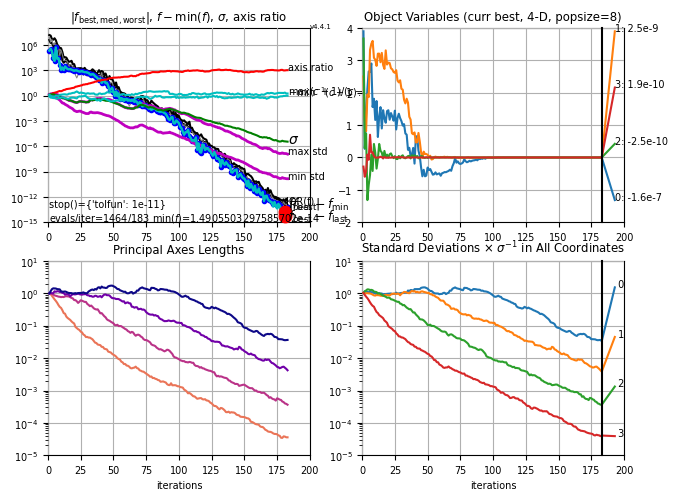

In [6]:
es = cma.CMAEvolutionStrategy(x0, sigma0)
while not es.stop():
    X = es.ask()
    F = [fun(x) for x in X]
    es.tell(X, F)
    es.disp()
    es.logger.add()  # write data for plotting
es.result_pretty()
es.plot();  # see below

A description of the output is given in the caption of Figure 3 in [Hansen et al (2015): Evolution Strategies](https://hal.inria.fr/hal-01155533/file/es-overview-2015.pdf#page=17). See also the [Plotting section below](#plotting).

# Options
CMA-ES options can be passed as fourth parameter to `cma.fmin2`. Valid options are

In [7]:
print(cma.__version__)
cma.CMAOptions()

4.4.1


{'AdaptSigma': 'True  # or False or any CMAAdaptSigmaBase class e.g. CMAAdaptSigmaTPA, CMAAdaptSigmaCSA',
 'CMA_active': 'True  # negative update, conducted after the original update',
 'CMA_active_injected': '0  #v weight multiplier for negative weights of injected solutions',
 'CMA_cmean': '1  # learning rate for the mean value',
 'CMA_const_trace': 'False  # normalize trace, 1, True, "arithm", "geom", "aeig", "geig" are valid',
 'CMA_diagonal': '0*100*N/popsize**0.5  # nb of iterations with diagonal covariance matrix, True for always',
 'CMA_diagonal_decoding': '0  # learning rate multiplier for additional diagonal update',
 'CMA_eigenmethod': 'np.linalg.eigh  # or cma.utilities.math.eig or pygsl.eigen.eigenvectors',
 'CMA_elitist': 'False  #v or "initial" or True, elitism likely impairs global search performance',
 'CMA_injections_threshold_keep_len': '1  #v keep length if Mahalanobis length is below the given relative threshold',
 'CMA_mirrors': 'popsize < 6  # values <0.5 are int

A `#v` indicates versatile options that can be changed at any time during the run by changing the `opts` attribute of the underlying [`CMAEvolutionStrategy`](https://cma-es.github.io/apidocs-pycma/cma.evolution_strategy.CMAEvolutionStrategy.html) class instance.

To run the code entirely quietly, for example for benchmarking or in repetitive production runs when the desired behavior is established, use `{'verbose': -9}`.

An often useful option to limit the output lines in long runs is `'verb_disp_overwrite'` setting the iteration number after which the console output lines are overwritten:

In [8]:
x, es = cma.fmin2(cma.ff.cigtab, 33 * [1], 1, options={'verb_disp_overwrite': 300})

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 33 (seed=792116, Wed Sep 24 03:22:07 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 5.469943673445845e+02 1.0e+00 9.45e-01  9e-01  1e+00 0:00.0
    2     28 7.596874432707230e+01 1.1e+00 9.07e-01  9e-01  9e-01 0:00.0
    3     42 6.035608998404242e+01 1.1e+00 8.72e-01  9e-01  9e-01 0:00.0
  100   1400 2.215002638671025e+02 2.8e+00 5.12e-01  3e-01  6e-01 0:00.1
  200   2800 3.047236569410198e+01 6.8e+00 3.65e-01  1e-01  4e-01 0:00.1
  300   4200 3.255302719576909e+00 1.4e+01 1.71e-01  2e-02  2e-01 0:00.2
 1210  16940 4.485380660699473e-14 6.4e+03 7.70e-08  5e-10  3e-06 0:00.7
termination on {'tolfun': 1e-11} (Wed Sep 24 03:22:09 2025)
final/bestever f-value = 2.527468e-14 2.527468e-14 after 16941/16941 evaluations
incumbent solution: [-6.58785948e-07  2.27031478e-10 -1.45002880e-08  2.92236833e-08
  5.79286580e-09  4.78393866e-08  4.72975530e-08 -6.10998144e-08 ...]
std deviations: [2.96583641e-

### Integer Variables
Integer variable indices can be indicated with the `integer_variables` option. Integer variables values are rounded (since version `4.2.1`). Technically, this option also induces for these variables
1. the setting a minimum standard deviation (like with option `'minstd'`) and
2. integer centering (Marty et al 2024).

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 4 (seed=815731, Wed Sep 24 03:22:09 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 3.575436918993154e+07 1.0e+00 2.58e+00  2e+00  3e+00 0:00.0
    2     24 7.589762093606292e+06 1.4e+00 3.43e+00  3e+00  4e+00 0:00.0
    3     36 4.053973494869540e+06 1.3e+00 4.11e+00  4e+00  4e+00 0:00.0
   86   1032 3.377689310618503e-07 6.8e+03 1.33e-02  2e-06  2e-01 0:00.0
termination on {'ftarget': 1e-06} (Wed Sep 24 03:22:09 2025)
final/bestever f-value = 1.203658e-07 1.203658e-07 after 1033/1033 evaluations
incumbent solution: [-0.00000000e+00, -1.95641589e-05, 0.00000000e+00, 2.86513755e-07]
std deviations: [2.00000000e-01, 1.93875637e-04, 2.00000000e-01, 1.69148210e-06]


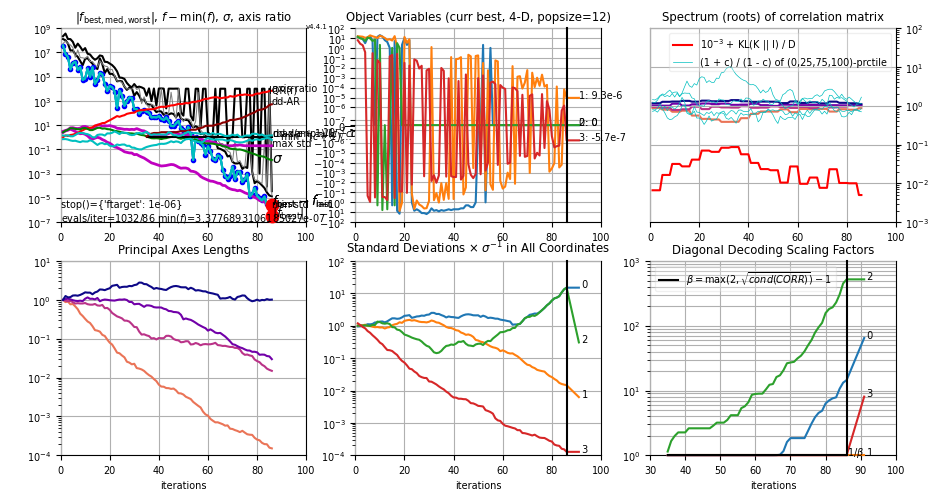

In [9]:
x, es = cma.fmin2(cma.ff.elli, 4 * [12], 2,
                  {'integer_variables':[0, 2], 'ftarget':1e-6})
es.plot(xsemilog=True);

In [10]:
print('f(best.x) = f({0})\n          = {1} = {2}'.format(es.best.x, es.best.f, cma.ff.elli(es.best.x)))
es.opts['minstd']

f(best.x) = f([-0.00000000e+00 -1.95641589e-05  0.00000000e+00  2.86513755e-07])
          = 1.203657633260661e-07 = 1.203657633260661e-07


array([0.2, 0. , 0.2, 0. ])

# Plotting
Let's plot some data from the optimization. The above call to `cma.fmin2` has (by default) written data to the default output folder `outcmaes`. These data will be overwritten each time the function is called again. To prevent this, we could set/change the output folder with the `verb_filenameprefix` option. An effective way to find out this kind of behavior is to query the [`CMAOptions`](https://cma-es.github.io/apidocs-pycma/cma.evolution_strategy.CMAOptions.html) with a search string and read the comments in the return "value".

In [11]:
cma.CMAOptions('file')

{'signals_filename': 'cma_signals.in  # read versatile options from this file which contains a single options dict, e.g. ``{"timeout": 0}`` to stop right away, some string-values are recognized, e.g. "np.inf" is valid, use `None` or `""` for no file',
 'verb_append': '0  # initial evaluation counter, if append, do not overwrite output files',
 'verb_filenameprefix': 'outcmaes/  # output path (folder) and filenames prefix',
 'verb_log': '1  #v verbosity: write data to files every verb_log iteration, writing can be time critical on fast to evaluate functions',
 'verbose': '3  #v verbosity e.g. of initial/final message and logging,\n -1 is very quiet, <=-9 is maximally quiet, <=-10 ignores the signals_filename'}

Plotting data of the latest executed run is as simple as

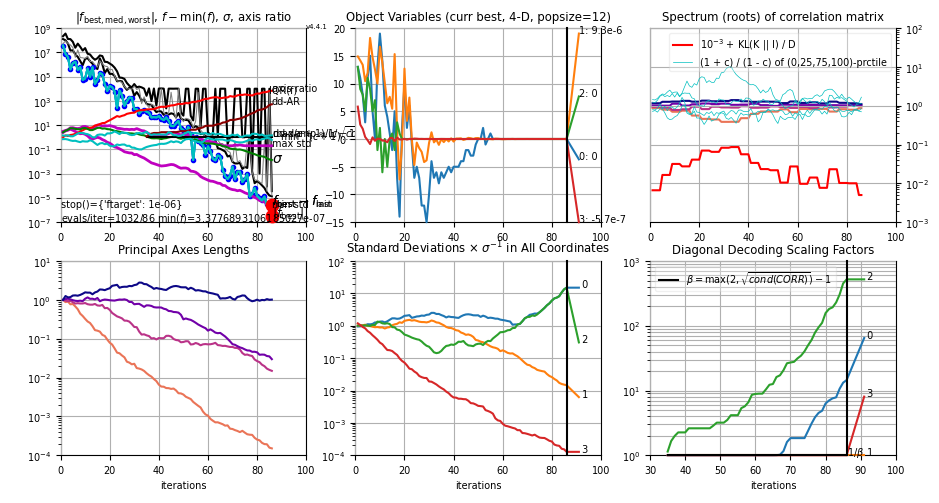

In [12]:
es.plot();  # cma.plot() does the same, as we just plot the data from the default output folder

A description of the output is given in the caption of Figure 3 in [Hansen et al (2015): Evolution Strategies](https://hal.inria.fr/hal-01155533/file/es-overview-2015.pdf#page=17).

# Domain Boundaries

We can add lower and upper domain boundaries on any variable. The easiest way is to use the function wrapper `BoundDomainTransform`. We bound the second variable from below to values $\ge1$:

In [13]:
lower_bounds = [None, 1, None]
bfun = cma.BoundDomainTransform(fun, [lower_bounds, None])  # bfun evaluates fun only in the bounded domain

xopt_b, es = cma.fmin2(bfun, x0, sigma0)  # fmin2 may search in an unbounded domain

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=776244, Wed Sep 24 03:22:11 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.617675110455171e+05 1.0e+00 1.05e+00  1e+00  1e+00 0:00.0
    2     16 2.947535745242303e+04 1.3e+00 1.32e+00  1e+00  2e+00 0:00.0
    3     24 5.103661891863953e+04 1.5e+00 1.71e+00  2e+00  2e+00 0:00.0
  100    800 1.000049100871286e+02 1.1e+03 2.50e-02  5e-05  5e-02 0:00.0
  190   1520 9.999999999999997e+01 9.7e+02 7.61e-07  3e-11  3e-08 0:00.1
termination on {'tolfun': 1e-11} (Wed Sep 24 03:22:11 2025)
final/bestever f-value = 1.000000e+02 1.000000e+02 after 1521/1473 evaluations
incumbent solution: [-2.56969574e-08, 9.49999998e-01, -1.74942401e-10, 1.70767102e-11]
std deviations: [3.29237575e-08, 8.84375967e-10, 2.83950059e-10, 3.44227521e-11]


All solutions from `es.result` need to be transformed with `bfun.transform` to represent solutions of `fun`.

In [14]:
x = es.result.xfavorite  # is not bounded
x, bfun.transform(x)

(array([-2.56969574e-08,  9.49999998e-01, -1.74942401e-10,  1.70767102e-11]),
 array([-2.56969574e-08,  1.00000000e+00, -1.74942401e-10,  1.70767102e-11]))

In [15]:
print("bfun(x) = bfun({0}) = {1} \n"
      "        =  fun({2}) = {3} \n"
      .format(x, bfun(x), bfun.transform(x), fun(bfun.transform(x))))

bfun(x) = bfun([-2.56969574e-08  9.49999998e-01 -1.74942401e-10  1.70767102e-11]) = 99.99999999999997 
        =  fun([-2.56969574e-08  1.00000000e+00 -1.74942401e-10  1.70767102e-11]) = 99.99999999999997 



It is _always_ advisable to have a (quick) look at the plotted results.

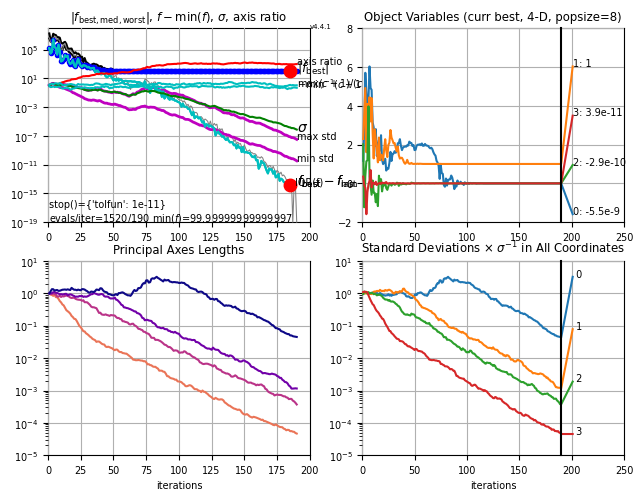

In [16]:
es.plot(xtransform=bfun.transform);  # show x-values (object variables) as evaluated on fun

Because we know the optimum, we can visually check the convergence behavior, revealing that _in the transformed space_ the second variable (orange with index 1) converges twice as fast as the others:

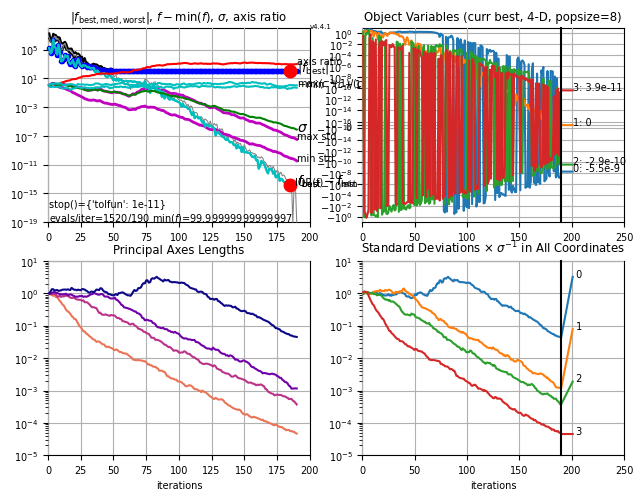

In [17]:
es.plot(xtransform=bfun.transform, xsemilog=True, x_opt=[0, 1] + (len(x0) - 2) * [0]
       );  # show evaluated x-values minus x_opt in symlog display

Alternatively to using `BoundDomainTransform`, the options provide a flexible choice of boundary handlers using the `'bounds'` and `'BoundaryHander'` options. We can find out about these option by calling

In [18]:
cma.CMAOptions('bound')  # returns options that contain "bound"

{'BoundaryHandler': 'BoundTransform  # or BoundPenalty, unused when ``bounds in (None, [None, None])``',
 'bounds': '[None, None]  # lower (=bounds[0]) and upper domain boundaries, each a scalar or a list/vector',
 'maxstd_boundrange': '1/3  # maximal std relative to bound_range per coordinate, overruled by maxstd'}

The default handler `BoundTransform` is based on the same code as `BoundDomainTransform`. In this case, the initial solution must be within the given bounds (it is, in our case). As above, `'bounds'` is a list of two values, `[lower_bounds, upper_bounds]`, where `lower_bounds` and `upper_bounds` can be a scalar that applies to all variables or a list. If the list is shorter than the initial solution, the last value is applied to the remaining dimensions.

Running the same example as above with the bounds option:

In [19]:
xopt_b, es_b = cma.fmin2(fun, x0, sigma0, {'bounds': [[None, 1, None], None]})

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=820713, Wed Sep 24 03:22:12 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.213987749643986e+05 1.0e+00 1.05e+00  1e+00  1e+00 0:00.0
    2     16 6.768817753648329e+04 1.4e+00 1.15e+00  1e+00  1e+00 0:00.0
    3     24 2.757041577137389e+05 1.4e+00 1.10e+00  1e+00  1e+00 0:00.0
  100    800 1.000000500191546e+02 1.4e+03 7.05e-03  8e-06  1e-02 0:00.0
  183   1464 9.999999999999997e+01 8.5e+02 1.73e-06  9e-11  7e-08 0:00.1
termination on {'tolfun': 1e-11} (Wed Sep 24 03:22:12 2025)
final/bestever f-value = 1.000000e+02 1.000000e+02 after 1465/1428 evaluations
incumbent solution: [-5.38063136e-09, 1.00000000e+00, -4.72796377e-10, -4.27147760e-14]
std deviations: [7.30540175e-08, 2.58164890e-09, 8.51951987e-10, 9.26132257e-11]


In [20]:
# now solutions _are_ transformed, however the mean is not (hence ``plot_mean=True`` should use ``.boundary_handler.transform``)
es_b.result.xbest, es_b.mean, es_b.boundary_handler.transform(es_b.mean)

(array([ 6.72268221e-08,  1.00000000e+00, -7.32057024e-10, -7.42051105e-11]),
 array([-5.38063136e-09,  9.50000001e-01, -4.72796377e-10, -4.27147760e-14]),
 array([-5.38063136e-09,  1.00000000e+00, -4.72796377e-10, -4.27147760e-14]))

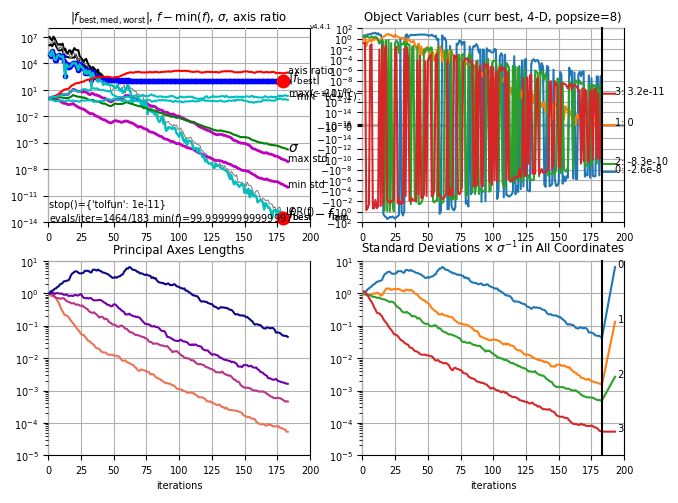

In [21]:
es_b.plot(xsemilog=True, x_opt=[0, 1] + (len(x0) - 2) * [0]);

# Rescaling of the Objective
In a practical application, the encoding of variables is often essential to turn a _very_ difficult problem into less difficult one, see also [here](https://cma-es.github.io/cmaes_sourcecode_page.html#practical). The simplest encoding is a rescaling.
This can be done with the [`cma.ScaleCoordinates`](https://cma-es.github.io/apidocs-pycma/cma.fitness_transformations.ScaleCoordinates.html) wrapping class.
An alternative, simpler and somewhat more transparent solution is a coordinate-wise scaling of the initial `sigma` with the option `'CMA_stds'`.
In contrast to [`cma.ScaleCoordinates`](https://cma-es.github.io/apidocs-pycma/cma.fitness_transformations.ScaleCoordinates.html), this is also directly compatible with integer variables.
The [`CMAOptions`](https://cma-es.github.io/apidocs-pycma/cma.evolution_strategy.CMAOptions.html) give again the hint where to look.

In [22]:
cma.CMAOptions('scale')

{'CMA_stds': 'None  # multipliers for sigma0 in each coordinate (not represented in C), or use `cma.ScaleCoordinates` instead',
 'scaling_of_variables': 'None  # deprecated, rather use fitness_transformations.ScaleCoordinates instead (or CMA_stds). WAS: Scale for each variable in that effective_sigma0 = sigma0*scaling. Internally the variables are divided by scaling_of_variables and sigma is unchanged, default is `np.ones(N)`'}

We rescale the ellipsoid function to its most benign form. In dimension 4, this saves (only) about 25% of the necessary evaluations.

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=815706, Wed Sep 24 03:22:13 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.094580797380821e+06 1.0e+00 9.97e-01  1e+00  1e+03 0:00.0
    2     16 1.599119281249682e+06 1.2e+00 8.58e-01  9e-01  8e+02 0:00.0
    3     24 3.642722265680713e+05 1.3e+00 8.42e-01  9e-01  7e+02 0:00.0
   82    656 9.701764887269812e-07 1.6e+00 6.28e-05  2e-06  2e-03 0:00.0
termination on {'ftarget': 1e-06} (Wed Sep 24 03:22:13 2025)
final/bestever f-value = 1.096416e-06 9.701765e-07 after 657/654 evaluations
incumbent solution: [-6.35647981e-04, -3.25929485e-05, 9.91647590e-07, -7.59146765e-07]
std deviations: [2.07950008e-03, 1.80435832e-04, 1.51009049e-05, 1.74186483e-06]


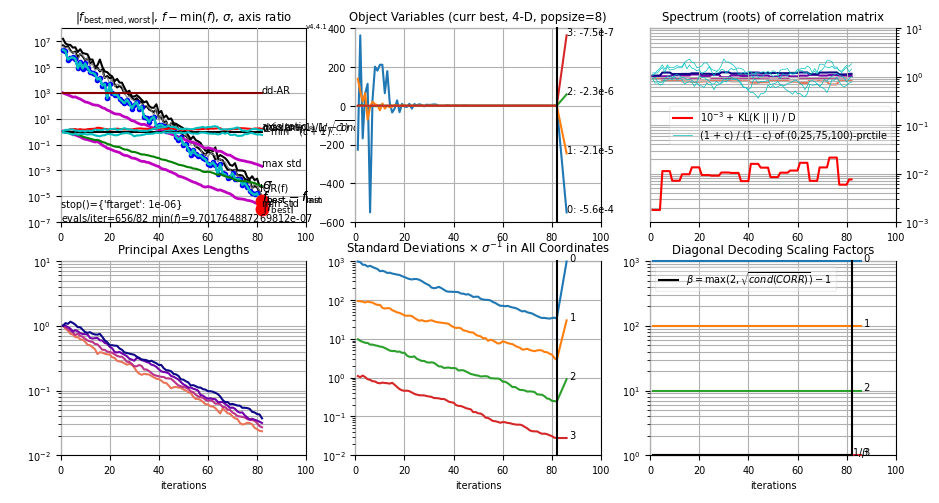

In [23]:
vec_sigma0 = [1e3 / 1e3**(i / 3) for i in range(4)]
xopt2, es2 = cma.fmin2(fun, x0, sigma0, {'CMA_stds': vec_sigma0, 'ftarget':1e-6})
cma.plot();

On the 40-dimension ellipsoid function, the saving is a factor of close to seven:

In [24]:
xopt40, es40 = cma.fmin2(fun, 40 * [2], sigma0, {'ftarget': 1e-6, 'verbose':-9})
vec_sigma0 = [1e3 / 1e3**(i / 39) for i in range(40)]
xopt0, es0 = cma.fmin2(fun, 40 * [2], sigma0, {'CMA_stds': vec_sigma0, 'ftarget': 1e-6, 'verbose':-9})

In [25]:
es40.result.fbest, es0.result.fbest, es40.result.evals_best / es0.result.evals_best

(4.871354657699783e-07, 7.466831661995007e-07, 7.265097079957193)

Without covariance matrix adaptation, the saving from rescaling is here _much_ more substantial, namely a factor of about $10\,000$, which can be inferred from Figure 10 in [Hansen and Ostermeier (2001)](http://www.cmap.polytechnique.fr/~nikolaus.hansen/publications.html#hansenaost2001).

# Advanced Options Settings
## Setting the step-size adaptation
Apart from the default cumulative step-size adaptation, another competitive way to adapt the step-size is the two-point step-size adaptation, TPA, see Equations (6)-(8) in [Akimoto and Hansen (2016)](https://hal.inria.fr/hal-01306551).

In [26]:
cma.CMAOptions('sigma')

{'AdaptSigma': 'True  # or False or any CMAAdaptSigmaBase class e.g. CMAAdaptSigmaTPA, CMAAdaptSigmaCSA',
 'CMA_dampsvec_fac': 'np.inf  # tentative and subject to changes, 0.5 would be a "default" damping for sigma vector update',
 'CMA_dampsvec_fade': '0.1  # tentative fading out parameter for sigma vector update',
 'CMA_stds': 'None  # multipliers for sigma0 in each coordinate (not represented in C), or use `cma.ScaleCoordinates` instead',
 'CSA_squared': 'False  #v use squared length for sigma-adaptation ',
 'scaling_of_variables': 'None  # deprecated, rather use fitness_transformations.ScaleCoordinates instead (or CMA_stds). WAS: Scale for each variable in that effective_sigma0 = sigma0*scaling. Internally the variables are divided by scaling_of_variables and sigma is unchanged, default is `np.ones(N)`',
 'stall_sigma_change_on_divergence_iterations': 'False  #v number of iterations of median worsenings threshold at which the sigma change is stalled; the default may become 2',
 'to

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=745883, Wed Sep 24 03:22:16 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.003785275283688e+05 1.0e+00 9.45e-01  9e-01  1e+00 0:00.0
    2     16 4.615340670661037e+04 1.3e+00 9.61e-01  9e-01  1e+00 0:00.0
    3     24 1.051511196143509e+04 1.3e+00 1.04e+00  9e-01  1e+00 0:00.0
  100    800 1.247176088169431e-05 9.0e+02 4.15e-03  5e-06  3e-03 0:00.1
  175   1400 8.054729732564950e-16 7.3e+02 7.08e-07  2e-11  2e-08 0:00.1
termination on {'tolfun': 1e-11} (Wed Sep 24 03:22:16 2025)
final/bestever f-value = 2.441976e-16 2.441976e-16 after 1401/1401 evaluations
incumbent solution: [ 4.58736581e-09, -1.48639757e-09, 8.34811029e-12, 1.23247234e-12]
std deviations: [1.66625862e-08, 2.51187379e-09, 2.12591120e-10, 2.30897902e-11]


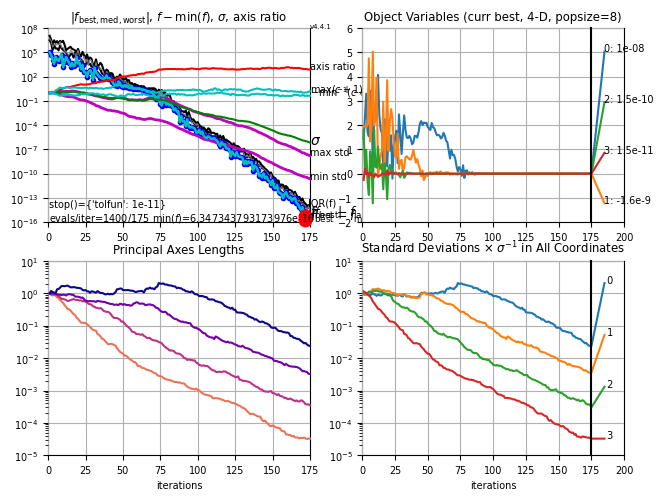

In [27]:
xopt, es = cma.fmin2(fun, x0, sigma0,
                     {'AdaptSigma': cma.sigma_adaptation.CMAAdaptSigmaTPA})
es.plot();

Without step-size adaptation, the "final" convergence stage of the optimization takes about 3 to 4 times longer (this effect becomes more pronounced in higher dimension):

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=740233, Wed Sep 24 03:22:17 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.101391050239725e+06 1.0e+00 1.00e+00  9e-01  1e+00 0:00.0
    2     16 2.577217338100305e+04 1.4e+00 1.00e+00  9e-01  1e+00 0:00.0
    3     24 7.062446425108712e+04 1.4e+00 1.00e+00  9e-01  1e+00 0:00.0
  100    800 7.915142179130454e-01 1.1e+03 1.00e+00  9e-04  1e+00 0:00.0
  200   1600 2.562332668589891e-05 9.4e+02 1.00e+00  1e-05  9e-03 0:00.1
  300   2400 4.188042972021839e-09 7.9e+02 1.00e+00  1e-07  9e-05 0:00.1
  400   3200 1.694419778419388e-13 1.4e+03 1.00e+00  7e-10  8e-07 0:00.1
  401   3208 4.373042117583565e-13 1.4e+03 1.00e+00  6e-10  8e-07 0:00.1
termination on {'tolfun': 1e-11} (Wed Sep 24 03:22:17 2025)
final/bestever f-value = 6.459382e-14 6.459382e-14 after 3209/3209 evaluations
incumbent solution: [1.01996298e-07, 2.14293744e-08, 8.28446157e-10, 3.74905481e-11]
std deviations: [8.06362684e-0

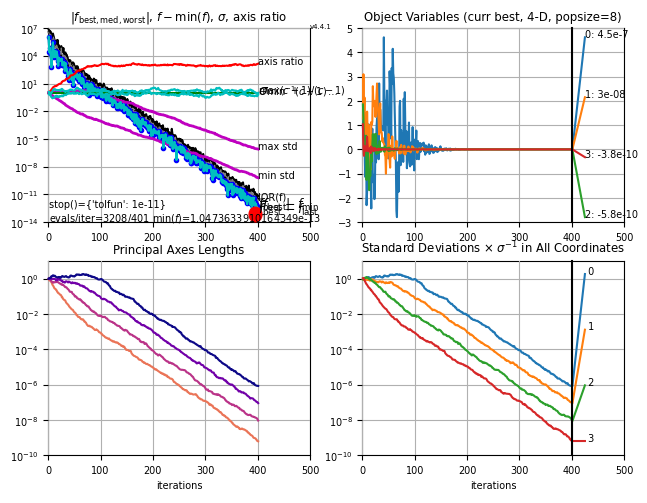

In [28]:
xopt, es = cma.fmin2(fun, x0, sigma0, {'AdaptSigma': False})
es.plot();

## Setting different learning rates (not basics)
A more research related option is the manual setting of learning rates. We can find the relevant options for the covariance matrix update like

In [29]:
cma.CMAOptions('covar')

{'CMA_diagonal': '0*100*N/popsize**0.5  # nb of iterations with diagonal covariance matrix, True for always',
 'CMA_on': '1  # multiplier for all covariance matrix updates',
 'CMA_rankmu': '1.0  # multiplier for rank-mu update learning rate of covariance matrix',
 'CMA_rankone': '1.0  # multiplier for rank-one update learning rate of covariance matrix',
 'tolconditioncov': '1e14  #v stop if the condition of the covariance matrix is above `tolconditioncov`'}

If we want to run CMA-ES only with rank-$\mu$ update, we set the learning rate for the rank-one update to zero. Then, to get a solution of the same quality on the 4-dimensional ellipsoid function, it takes on average about 15% more iterations.

In [30]:
xopt, es = cma.fmin2(fun, x0, sigma0, {'CMA_rankone': 0})

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=804323, Wed Sep 24 03:22:17 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.023478940741423e+06 1.0e+00 1.30e+00  1e+00  2e+00 0:00.0
    2     16 2.495167807871910e+03 1.3e+00 1.37e+00  1e+00  1e+00 0:00.0
    3     24 7.741033283452464e+04 1.2e+00 1.41e+00  1e+00  2e+00 0:00.0
  100    800 8.571025334112901e+00 3.0e+02 6.71e-02  5e-04  2e-01 0:00.0
  200   1600 3.792541359507427e-10 1.0e+03 1.48e-05  1e-08  1e-05 0:00.1
  238   1904 5.391017518552298e-14 1.4e+03 3.90e-07  1e-10  2e-07 0:00.1
termination on {'tolfun': 1e-11} (Wed Sep 24 03:22:18 2025)
final/bestever f-value = 2.467222e-14 1.820496e-14 after 1905/1894 evaluations
incumbent solution: [-1.96597573e-08, 9.56553734e-09, -1.16524501e-09, 3.94690846e-11]
std deviations: [1.89618017e-07, 1.78528870e-08, 1.50410289e-09, 1.41060642e-10]


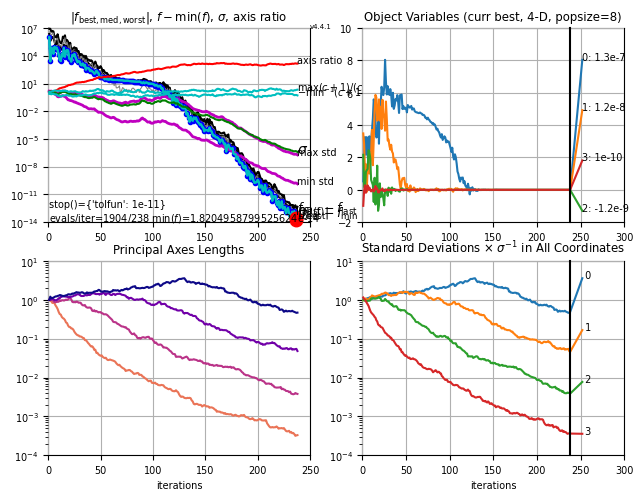

In [31]:
es.plot();

# See Also

This and other [`notebooks and recipes`](https://github.com/CMA-ES/pycma/tree/development/notebooks) can be found at https://github.com/CMA-ES/pycma/tree/development/notebooks

More `notebook / recipes` to come...